# Binary classification with the crabs data

The package is designed to handle models of the following general form
$$\begin{aligned}
\mathbf{y} \ |\ \mathbf{f}, \theta &\sim  \prod_{i=1}^n p(y_i \ | \ f_i,\theta), \\
    \mathbf{f} \ | \ \theta &\sim \mathcal{GP}\left(m_{\theta}(\mathbf{x}), k_{\theta}(\mathbf{x}, \mathbf{x}')\right),\\
      \theta &\sim p(\theta), 
\end{aligned}$$
where $\mathbf{y}=(y_1,y_2,\ldots,y_n) \in \mathcal{Y}$ and $\mathbf{x} \in \mathcal{X}$ are the observations and covariates, respectively, and $f_i:=f(\mathbf{x}_i)$ is the latent function which we model with a Gaussian process prior. We assume that the responses $\mathbf{y}$ are independent and identically distributed and as a result the likelihood $p(\mathbf{y} \ | \ \mathbf{f}, \theta)$, can be factorized over the observations. 

In the case where the observations are Gaussian distributed, the marginal likelihood and predictive distribution can be derived analytically. See the  [Regression notebook](https://github.com/STOR-i/GaussianProcesses.jl/blob/master/notebooks/Regression.ipynb) for an illustration.

In this example we show how the GP **Monte Carlo** function can be used for **supervised learning classification**. We use the Crab dataset from the R package MASS. In this dataset we are interested in predicting whether a crab is of colour form blue or orange. Our aim is to perform a Bayesian analysis and calculate the posterior distribution of the latent GP function $\mathbf{f}$ and model parameters $\theta$ from the training data $\{\mathbf{X}, \mathbf{y}\}$.

In [17]:
using GaussianProcesses, RDatasets
import Distributions:Normal

srand(113355)

crabs = dataset("MASS","crabs");              # load the data 
crabs = crabs[shuffle(1:size(crabs)[1]), :];  # shuffle the data

train = crabs[1:div(end,2),:];

y = Array{Bool}(size(train)[1]);           # response
y[train[:Sp].=="B"]=0;                      # convert characters to booleans
y[train[:Sp].=="O"]=1;

X = convert(Array,train[:,4:end]);          # predictors

We assume a zero mean GP with a Matern 3/2 kernel. We use the automatic relevance determination (ARD) kernel to allow each dimension of the predictor variables to have a different length scale. As this is binary classifcation, we use the Bernoulli likelihood, 

$$
y_i \sim Bernoulli(\Phi(f_i))
$$
where $\Phi: \mathbb{R} \rightarrow [0,1]$ is the cumulative distribution function of a standard Gaussian and acts as a squash function that maps the GP function to the interval [0,1], giving the probability that $y_i=1$. 

**Note** that `BernLik` requires the observations to be of type `Bool` and unlike some likelihood functions (e.g. student-t) does not contain any parameters to be set at initialisation.

In [18]:
#Select mean, kernel and likelihood function
mZero = MeanZero();                # Zero mean function
kern = Matern(3/2,zeros(5),0.0);   # Matern 3/2 ARD kernel (note that hyperparameters are on the log scale)
lik = BernLik();                   # Bernoulli likelihood for binary data {0,1}

We fit the GP using the general `GP` function. This function is a shorthand for the `GPMC` function which is used to generate **Monte Carlo approximations** of the latent function when the **likelihood is non-Gaussian**. 

In [19]:
gp = GP(X',y,mZero,kern,lik)      # Fit the Gaussian process model

GP Monte Carlo object:
  Dim = 5
  Number of observations = 100
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Any[]
  Kernel:
    Type: GaussianProcesses.Mat32Ard, Params: [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0]
  Likelihood:
    Type: GaussianProcesses.BernLik, Params: Any[]
  Input observations = 
[16.2 11.2 … 11.6 18.5; 13.3 10.0 … 9.1 14.6; … ; 41.7 26.9 … 28.4 42.0; 15.4 9.4 … 10.4 16.6]
  Output observations = Bool[false, false, false, false, true, true, false, true, true, true  …  false, true, false, false, false, true, false, false, false, true]
  Log-posterior = -161.209

We assign `Normal` priors from the `Distributions` package to each of the Matern kernel parameters. If the mean and likelihood function also contained parameters, then we could set these priors in the same using `gp.m` and `gp.lik` in place of `gp.k`, respectively.

In [20]:
set_priors!(gp.k,[Normal(0.0,2.0) for i in 1:6])

6-element Array{Distributions.Normal{Float64},1}:
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)
 Distributions.Normal{Float64}(μ=0.0, σ=2.0)

Samples from the posterior distribution of the latent function and parameters $f, \theta | X,y$, are drawn using MCMC sampling. The `mcmc` function uses a Hamiltonain Monte Carlo sampler. By default, the function runs for `nIter=1000` iterations, uses a step-size of $\epsilon=0.01$ with a random number of leap-frog steps $L$ between 5 and 15. 

In [21]:
samples = mcmc(gp;nIter=5000);
thinned_samples = samples[500:10:end,:]; #thin the samples after first 1,000 to reduce autocorrelation

We test the predictive accuracy of the fitted model against a hold-out dataset

In [22]:
test = crabs[div(end,2)+1:end,:];          # select test data

yTest = Array{Bool}(size(test)[1]);        # test response data
yTest[test[:Sp].=="B"]=0;                  # convert characters to booleans
yTest[test[:Sp].=="O"]=1;

xTest = convert(Array,test[:,4:end]);

Using the posterior samples $\{f^{(i)},\theta^{(i)}\}_{i=1}^N$ from $p(f,\theta \ | \ X,y)$ we can make predictions $\hat{y}$ using the `predict_y` function to sample predictions conditional on the MCMC samples.

In [23]:
ymean = Array{Float64}(size(thinned_samples,1),size(xTest,1));

for i in 1:size(thinned_samples,1)
    set_params!(gp,thinned_samples[i,:])
    update_target!(gp)
    ymean[i,:] = predict_y(gp,xTest')[1]
end

For each of the posterior samples we plot the predicted observation $\hat{y}$ (given as lines) and overlay the true observations from the held-out data (circles).


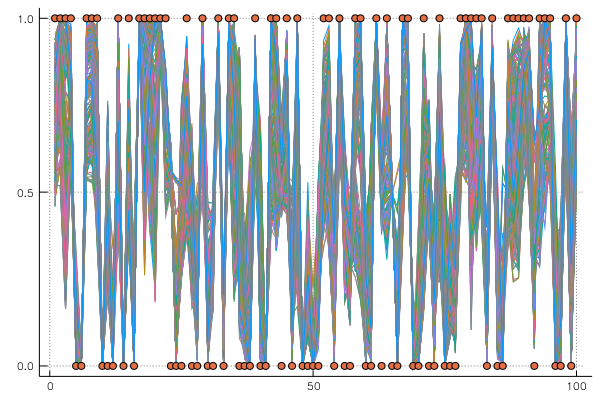

In [24]:
using Plots
gr()

plot(ymean',leg=false,html_output_format=:png)
scatter!(yTest)